In [13]:
import sys
import os
from scipy.io import wavfile
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_folder = os.environ["DATA_DIR"]

Ok, let's load in the data. For this dataset, $x \in R^{16,000}$ (16,000 samples = 1 second) and each sequence is 50 elements long, so each sequence corresponds to 50 seconds of audio.

In [4]:
with open(data_folder + os.path.sep + "x1_50_all.pkl") as f:
    dat = pickle.load(f)

In [5]:
X_train, X_valid, X_test = dat[0]

In [6]:
X_train.shape, X_valid.shape, X_test.shape

((174, 50, 16000), (21, 50, 16000), (21, 50, 16000))

We will need to re-instantiate our trained model. We will copy some code out of `experiments/22feb_testing_a_rmsprop.py` to achieve this.

In [7]:
args = dict()
args["seed"] = 0
args["batch_size"] = 16
args["learning_rate"] = 0.01
args["momentum"] = 0.9
args["num_epochs"] = 2000
args["X_train"] = X_train
args["X_valid"] = X_valid
args["X_test"] = X_test
args["update_method"] = rmsprop

args["config"] = "../configurations/19feb_testing_d.py"

Let's have a look at the network architecture/config as well.

In [10]:
%%bash
cat ../configurations/19feb_testing_d.py

import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import sys

def get_net(args):
    # e.g. (bs, 50, 1800)
    X_train = args["X_train"]
    num_inputs = X_train.shape[2]
    seq_length = X_train.shape[1] # determined by pkl

    num_hidden_units = 600

    if "seq_length" not in args:
        seq_length = X_train.shape[1]
    else:
        seq_length = args["seq_length"]

    l_input = InputLayer((None, seq_length, num_inputs))
    l_forward = LSTMLayer(l_input, num_units=num_hidden_units, unroll_scan=False, precompute_input=True)
    l_forward2 = LSTMLayer(l_forward, num_units=num_hidden_units, unroll_scan=False, precompute_input=True)
    l_forward3 = LSTMLayer(l_forward2, num_units=num_hidden_units, unroll_scan=False, precompute_input=True)

    """
    In order to connect a recurrent layer to a dense layer, we need to
    flatten the first two dimensions (our "s

In [8]:
sys.path.append("..")
import rnn_experiment as exp
symbols = exp.prepare(args)
out_fn = symbols["out_fn"]
l_out = symbols["l_out"]
with open(data_folder + os.path.sep + "expensive_models" + os.path.sep + "22feb_testing_a_rmsprop.model") as f:
    model = pickle.load(f)
set_all_param_values(l_out, model)

loading config: ../configurations/19feb_testing_d.py
Number of params in model: 55232200


Ok, let's make the first 50 seconds of `X_train` our seed sequence. That means we will get a sequence $x^{(1)}, \dots, x^{(100)}$. When we feed this sequence into the RNN, we will obtain a new predicted sequence $x^{(2)}, \dots, x^{(101)}$, from which we will obtain $x^{(101)}$. Then, we will feed $x^{(2)}, \dots, x^{(101)}$ into the RNN to obtain $x^{(3)}, \dots, x^{(102)}$, from which we will obtain $x^{(102)}$ and vice versa.

In [9]:
generated_seq = X_train[0:1].flatten().tolist()
prev_seq_chunk = X_train[0:1]
for x in range(0, 100):
    next_seq_chunk = out_fn(prev_seq_chunk) # x2, ..., x1001
    generated_seq += next_seq_chunk[0][-1].flatten().tolist() # append x1001 to end
    prev_seq_chunk = next_seq_chunk

How many seconds of audio did we generate?

In [12]:
float(len(generated_seq)) / 16000.0

100.0

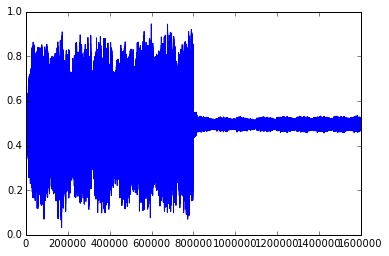

In [13]:
plt.plot(generated_seq)
plt.show()

Ok, now we need to re-scale the generated sequence back into its original values.

In [15]:
fs, data = wavfile.read(data_folder + os.path.sep + "data.wav")
data = np.asarray(data, dtype="float32")
this_min, this_max = np.min(data), np.max(data)

In [31]:
tmp = np.asarray(generated_seq)
tmp = (tmp * (this_max - this_min)) + this_min
tmp = np.asarray(tmp, dtype="int16")

In [32]:
wavfile.write(filename="/tmp/t.wav", rate=fs, data=tmp)

In [28]:
np.min(tmp), np.max(tmp)

(-1377, 15107)

Also plot learning curve.

In [19]:
import pandas as pd

In [20]:
df = pd.read_csv("../models/22feb_testing_a_rmsprop.txt")

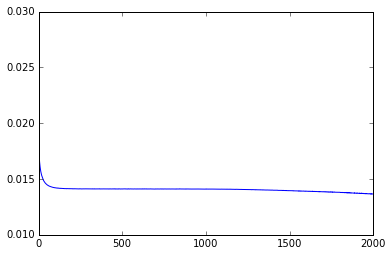

In [30]:
plt.ylim((0.010, 0.03))
plt.plot(df["train_loss"])
plt.show()

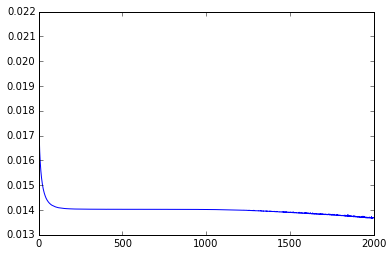

In [27]:
plt.plot(df["valid_loss"])
plt.show()